# Etapa 1: transcrição da partitura

## motivações
Uma análise da partitura de *Kurze Schatten II* (FERNEYHOUGH, 1990) pelos métodos analíticos mais tradicionais é um desafio, devido à complexidade da notação e dos processos de organização característicos do compositor. Por exemplo, a identificação de motivos é ambígua, devido à constante variação do material, que tende a escapar de uma tipologia muito evidente. Assim, surgiu a ideia de aplicar procedimentos/metodologias da área de *Machine Learning*, utilizadas em análise de situações complexas, em diversas áreas científicas.

A abordagem analítica passou pela transcrição da partitura (software *Lilypond*, __https://lilypond.org/__) a partir da versão publicada, sua conversão em formato midi e a posterior criação de uma tabela (pandas *DataFrame*, linguagem *Python*, __https://pandas.pydata.org/__) com diversas informações extraídas diretamente da partitura e com análises parciais de certos aspectos da mesma (ex: distâncias entre ataques, pc-sets, intervalos, etc).

A proposta pode ser definida com uma análise computacional da referida tabela, combinando procedimentos estatísticos automáticos com escolhas e direcionamentos de uma escuta/interpretação pessoal do analista.

## transcrição do ritmo
A transcrição da partitura apresentou uma dificuldade inicial relacionada ao ritmo. A complexidade das quiálteras aninhadas (*nested tuplets*) exigiu uma avaliação cuidadosa de cada compasso, de forma a capturar o ritmo corretamente. Diversos textos sobre a rítmica de Ferneyhough (FERNEYHOUGH, 1995; MALT, 1999) revelam a estratégia do compositor de utilizar prolações em vários níveis, ou seja, dividir os compassos segundo proporções e, em seguida, subdividir novamente as durações resultantes, segundo outras proporções. Esse processo pode se repetir recursivamente e se reflete na notação com a presença das quiálteras aninhadas.

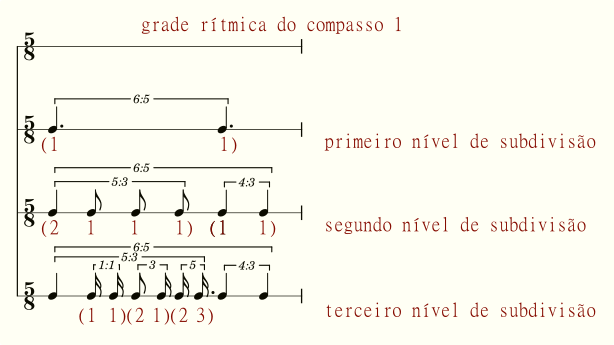

O exemplo acima mostra a grade rítmica de um compasso hipotético, apenas para demonstrar o procedimento de subdivisão do ritmo. A grade é o ritmo de base para gerar o compasso, que ainda deve ser filtrado - algumas durações são substituídas por pausas - para gerar o ritmo final. Há três níveis de subdivisão:
1. o primeiro nível divide o compasso segundo a proporção (1 1), ou seja em duas partes iguais;
2. o segundo nível divide cada uma das durações geradas no nível anterior pelas proporções (2 1 1 1) e (1 1). A presença do número 2 indica que sua duração deve ser o dobro das três seguintes;
3. o terceiro nível se aplica apenas a algumas das durações geradas no nível anterior e utiliza as proporções (1 1), (2 1) e (2 3).

Uma dificuldade na *engenharia reversa* da descoberta das proporções utilizadas em cada compasso passa pelo fato de que diferentes proporções podem levar a um mesmo resultado, ou seja, não há um modo único de se alcançar um mesmo ritmo final. Isso passa pelas ambiguidades da notação musical. Por exemplo, um compasso de 5/8 dividido pela proporção (1 1) - duas partes iguais - pode ser escrito de duas formas diferentes: 

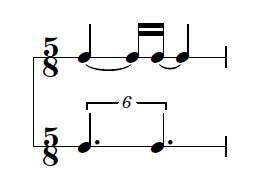

A primeira forma de notação poderia ser interpretada como sendo gerada pelas proporções (2 1 2) no primeiro nível e subdivisão do valor central por (1 1), no segundo nível. Em seguida os dois valores iniciais e finais seriam ligados. A segunda forma de notar (quiáltera) representa de modo mais direto a divisão do compasso em duas partes iguais.

Assim, o objetivo da transcrição foi capturar proporções que levariam ao ritmo escrito na partitura, sem garantias de tenham sido as mesmas utilizadas pelo compositor em seus esboços. Nos importava capturar as durações de cada evento (nota ou acorde) em milisegundos, de forma a incluir esse dado na tabela, sem nos atermos à forma particular como o compositor notou cada passagem. Que fique claro que a forma de notação do compositor pode ser uma fonte de observações muito importantes sobre o trabalho de composição. Apenas não foi o foco nesta etapa do trabalho. Isso explica as diferenças de notação da partitura transcrita com a original.

## algoritmo para transcrição do ritmo
Foi desenvolvido um algoritmo na biblioteca *Abjad* (__https://abjad.github.io/__) para transcrição do ritmo a partir dos seguintes dados: tamanho do compasso, proporções de subdivisão em três níveis. Esse algoritmo transcreve uma primeira versão do ritmo da partitura para o Lilypond. A partir dessa versão, foram introduzidas manualmente diversas modificações, como a inclusão de pausas/ligaduras e notas na partitura final (realizadas no editor *Frescobaldi*, __https://frescobaldi.org/__). 

A função que gera a grade rítmica se chama **prolation**. <br>
Exemplo de geração da grade rítmica do compasso 1: <br>
`x = prolation([5,8], [1,1], [0,1], [[2,1,1,1], [1,1]], [1,2,3], [[1,1],[2,1],[2,3]])
abjad.show(x)` <br>
Os argumentos da função acima se correspondem, respectivamente, a:
- `[5,8]` => duração do compasso;
- `[1,1]` => proporção para primeiro nível de subdivisão;
- `[0,1]` => posição das notas que serão subdivididas na próximo nível. Em Python as posições são contadas a partir de zero. No caso, [0,1] indica as duas notas iniciais geradas pelo nível 1;
- `[[2,1,1,1], [1,1]]` => cada uma das listas representa as proporções do segndo nível de subdivisão;
- `[1,2,3]` => o resultado do segundo nível de subdivisão tem 6 notas. [1,2,3] refere-se que as segunda, terceira e quarta notas serão novamente subdivididas no terceiro nível;
- `[[1,1], [2,1], [2,3]]` => proporções que subdividem cada uma das notas seleciondas anteriormente.
<br> O comando `abjad.show()` cria o pdf com a notação da grade rítmica.

Há uma segunda função **prolation_seq** que cria as grades rítmicas para uma sequência de compassos, cada qual com suas prolações em vários níveis. A entrada dessa função é um dicionário, com os dados associados a cada compasso.

### Códigos Python

Seguem os códigos dos algoritmos descritos acima.

In [1]:
import abjad
import copy

In [2]:
# auxiliary function:
#
def subd_event_dur(staff, posn, prop):
    'subdivide one duration of a staff container based in a proportion'
    items = abjad.select.logical_ties(staff)
    abjad.mutate.logical_tie_to_tuplet(items[posn], prop)
    return staff

In [3]:
# principal function
#
def prolation(cp, prop1=[1], posn=[], prop2=[], posn2=[], prop3=[], mode='all'):
    '''
    args: bar duration // proportion 1 
    // positions of events to subdivide with proportion 2 // proportion 2
    // positions of events to subdivide with proportion 3 // proportion 3
    mode => duas opções: 1) all (retorna várias pautas na grade) // 2) one (retorna apenas a pauta resultante)
    gen_tuplet([5,8], [1,1], [0, 1], [[2,1,1,1], [2,1]], [1,2,3], [[1,1],[2,1],[2,3]]) ==>

    'prolation' é a função mais abrangente, permitindo subdividir um compasso
    em três níveis de subdivisão, cada qual com sua lista de proporções.
    A função retorna uma abjad.Score com duas ou mais Staff ([global_staff, staff1, staff2, ...]),
    a global sendo responsável pela indicação métrica".
    O argumento mode ('all' ou 'one') permite duas saídas da função:
        'all' ==> várias pautas em paralelo, com as etapas sucessivas das subdivisões do compasso;
        'one' ==> apenas a pauta final.
    '''
    #### ajustar nova lista de posições
    len_lst = [len(i) for i in prop2]
    accum_lst = [0]
    v = 0
    for i in len_lst:
        v += i
        accum_lst.append(v)
    new_posn_lst = []
    for i in range(len(posn)):
        x = posn[i] + accum_lst[i] - i
        new_posn_lst.append(x)

    #### pauta inicial
    ts = abjad.TimeSignature(cp)
    sk = abjad.Skip((1,1), multiplier=cp)
    global_st = abjad.Staff([sk], lilypond_type="RhythmicStaff")
    abjad.attach(ts, global_st[0])

    #### pauta 2
    dur = abjad.Duration(cp)
    tup = abjad.makers.tuplet_from_duration_and_ratio(dur, prop1)
    st2 = abjad.Staff([tup], lilypond_type="RhythmicStaff")
    first_leaf = abjad.select.leaf(st2, 0)
    abjad.attach(abjad.TimeSignature(cp), first_leaf)

    #### pauta 3
    st3 = copy.deepcopy(st2)
    for pos, prop in zip(new_posn_lst, prop2):
        subd_event_dur(st3, pos, prop)
    first_leaf = abjad.select.leaf(st3, 0)
    abjad.attach(abjad.TimeSignature(cp), first_leaf)

    #### ajustar nova lista de posições
    len_lst2 = [len(i) for i in prop3]
    accum_lst2 = [0]
    v2 = 0
    for i in len_lst2:
        v2 += i
        accum_lst2.append(v2)
    new_posn_lst2 = []
    for i in range(len(posn2)):
        x = posn2[i] + accum_lst2[i] - i
        new_posn_lst2.append(x)

    #### pauta 4
    st4 = copy.deepcopy(st3)
    for pos, prop in zip(new_posn_lst2, prop3):
        subd_event_dur(st4, pos, prop)
    first_leaf = abjad.select.leaf(st4, 0)
    abjad.attach(abjad.TimeSignature(cp), first_leaf)

    #### selecionar quantas pautas devem aparecer na saída
    if mode == 'all':
        n2 = len(prop2)
        n3 = len(prop3)
        if n3 > 0:
            return abjad.Score([global_st, st2, st3, st4])
        elif n2 > 0:
            return abjad.Score([global_st, st2, st3])
        else:
            return abjad.Score([global_st, st2])
    elif mode == 'one':
        return st4
    else:
        print("mode argument only accepts the options 'all' or 'one'.")


In [4]:
def prolation_seq(cps_dict):
    '''
    Notação de uma sequência de compassos a partir de um dicionário
    key = número do compasso (string) 
    value = [cp, prop1, posn, prop2] (dados de cada compasso) 
    '''
    temp = []
    for i in cps_dict.keys():
        data = cps_dict[i]
        if len(data) == 6:
            sco = prolation(data[0],data[1],data[2],data[3],data[4],data[5], mode='one')
        elif len(data) == 4:
            sco = prolation(data[0],data[1],data[2],data[3], mode='one')
        else:
            sco = prolation(data[0],data[1], mode='one')
        temp.append(sco)

    st = temp[0]
    for i in temp[1:]:
        st.extend(i)
        
    return st

### Exemplo de uso das funções:

In [6]:
x = prolation([5,8], [1,1], [0,1], [[2,1,1,1], [1,1]], [1,2,3], [[1,1],[2,1],[2,3]])
abjad.show(x)

A opção `mode` define quantas pautas devem aparecer no pdf. O default é `mode='all'`, que mostra a pauta resultante do terceiro nível de subdivisão e os níveis intermediários, verticalmente agrupados. `mode='one'` mostra apenas a pauta resultante final.

In [7]:
x = prolation([5,8], [1,1], [0,1], [[2,1,1,1], [1,1]], [1,2,3], [[1,1],[2,1],[2,3]], mode='one')
abjad.show(x)

O exemplo seguinte mostra a criação de um dicionário com vários compassos e a utilização da função **prolation_seq**:

In [8]:
cps_dict = {} # [cp, prop1, posn, prop2]
cps_dict['cp1'] = [[5,8], [1]]
cps_dict['cp2'] = [[3,8], [1,2], [0], [[3,1]]]
cps_dict['cp3'] = [[4,8], [8,7]]
cps_dict['cp4'] = [[7,16], [4,8,5], [0], [[3,2]]]
cps_dict['cp5'] = [[15,32], [8,7], [0,1], [[2,1],[3,4]]]

st = prolation_seq(cps_dict)
abjad.show(st)

### Filtragem de ataques

In [9]:
# cp1 da partitura
x = prolation([5,8], [1,1], [0], [[2,1,2,1,2,3]])
abjad.show(x)

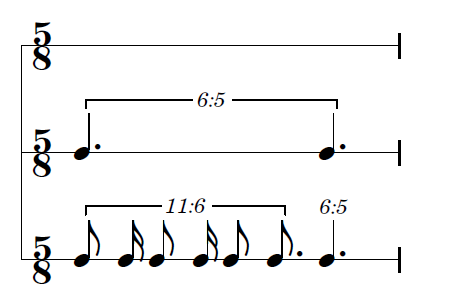

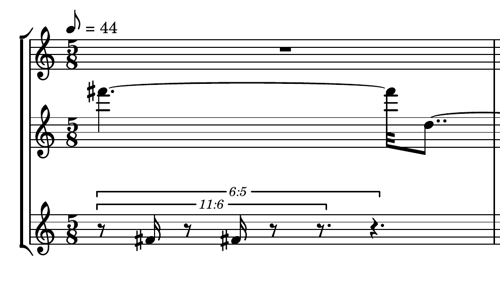

## Problemas encontrados na transcrição da partitura

compassos com alterações:
- cp2 => tamanho da pausa na pauta2;
    - caso se mantivesse a pausa de colcheia da partitura original, o ataque do Mi6 (pauta2) seria quase simultâneo ao Do5 (oitava nota da pauta3);
    - assim, a pausa foi alterada para semicolcheia, de modo que o Mi6 (pauta2) precedesse o ataque do Fa#3 (pauta3).
- cp4,6,7, => supressão da polifonia na pauta3;
    - como a polifonia da pauta3 é de menor importância, foi útil suprimí-la, ajustando as durações para manter a sequência correta dos ataques no compasso;
    - o objetivo foi simplificar a análise automática, sobretudo o cáculo das distâncias entre ataques.
- cp14 => inserção de pausa de colcheia no fim da pauta1
    - a duração da pauta1 não fecha corretamente;
    - há uma menção a isso em (**CITAR**).
- cp15 => mudança de quiálteras.
    - foi necessário alterar a proporção da subdivisão de 5 para 7 para manter a consistência rítmica das figuras.
- não foram transcritas dinâmicas, indicações de timbre, cordas e mudanças de agógica. 
    - essas informações serão consideradas em uma etapa posterior.

### Partitura gerada

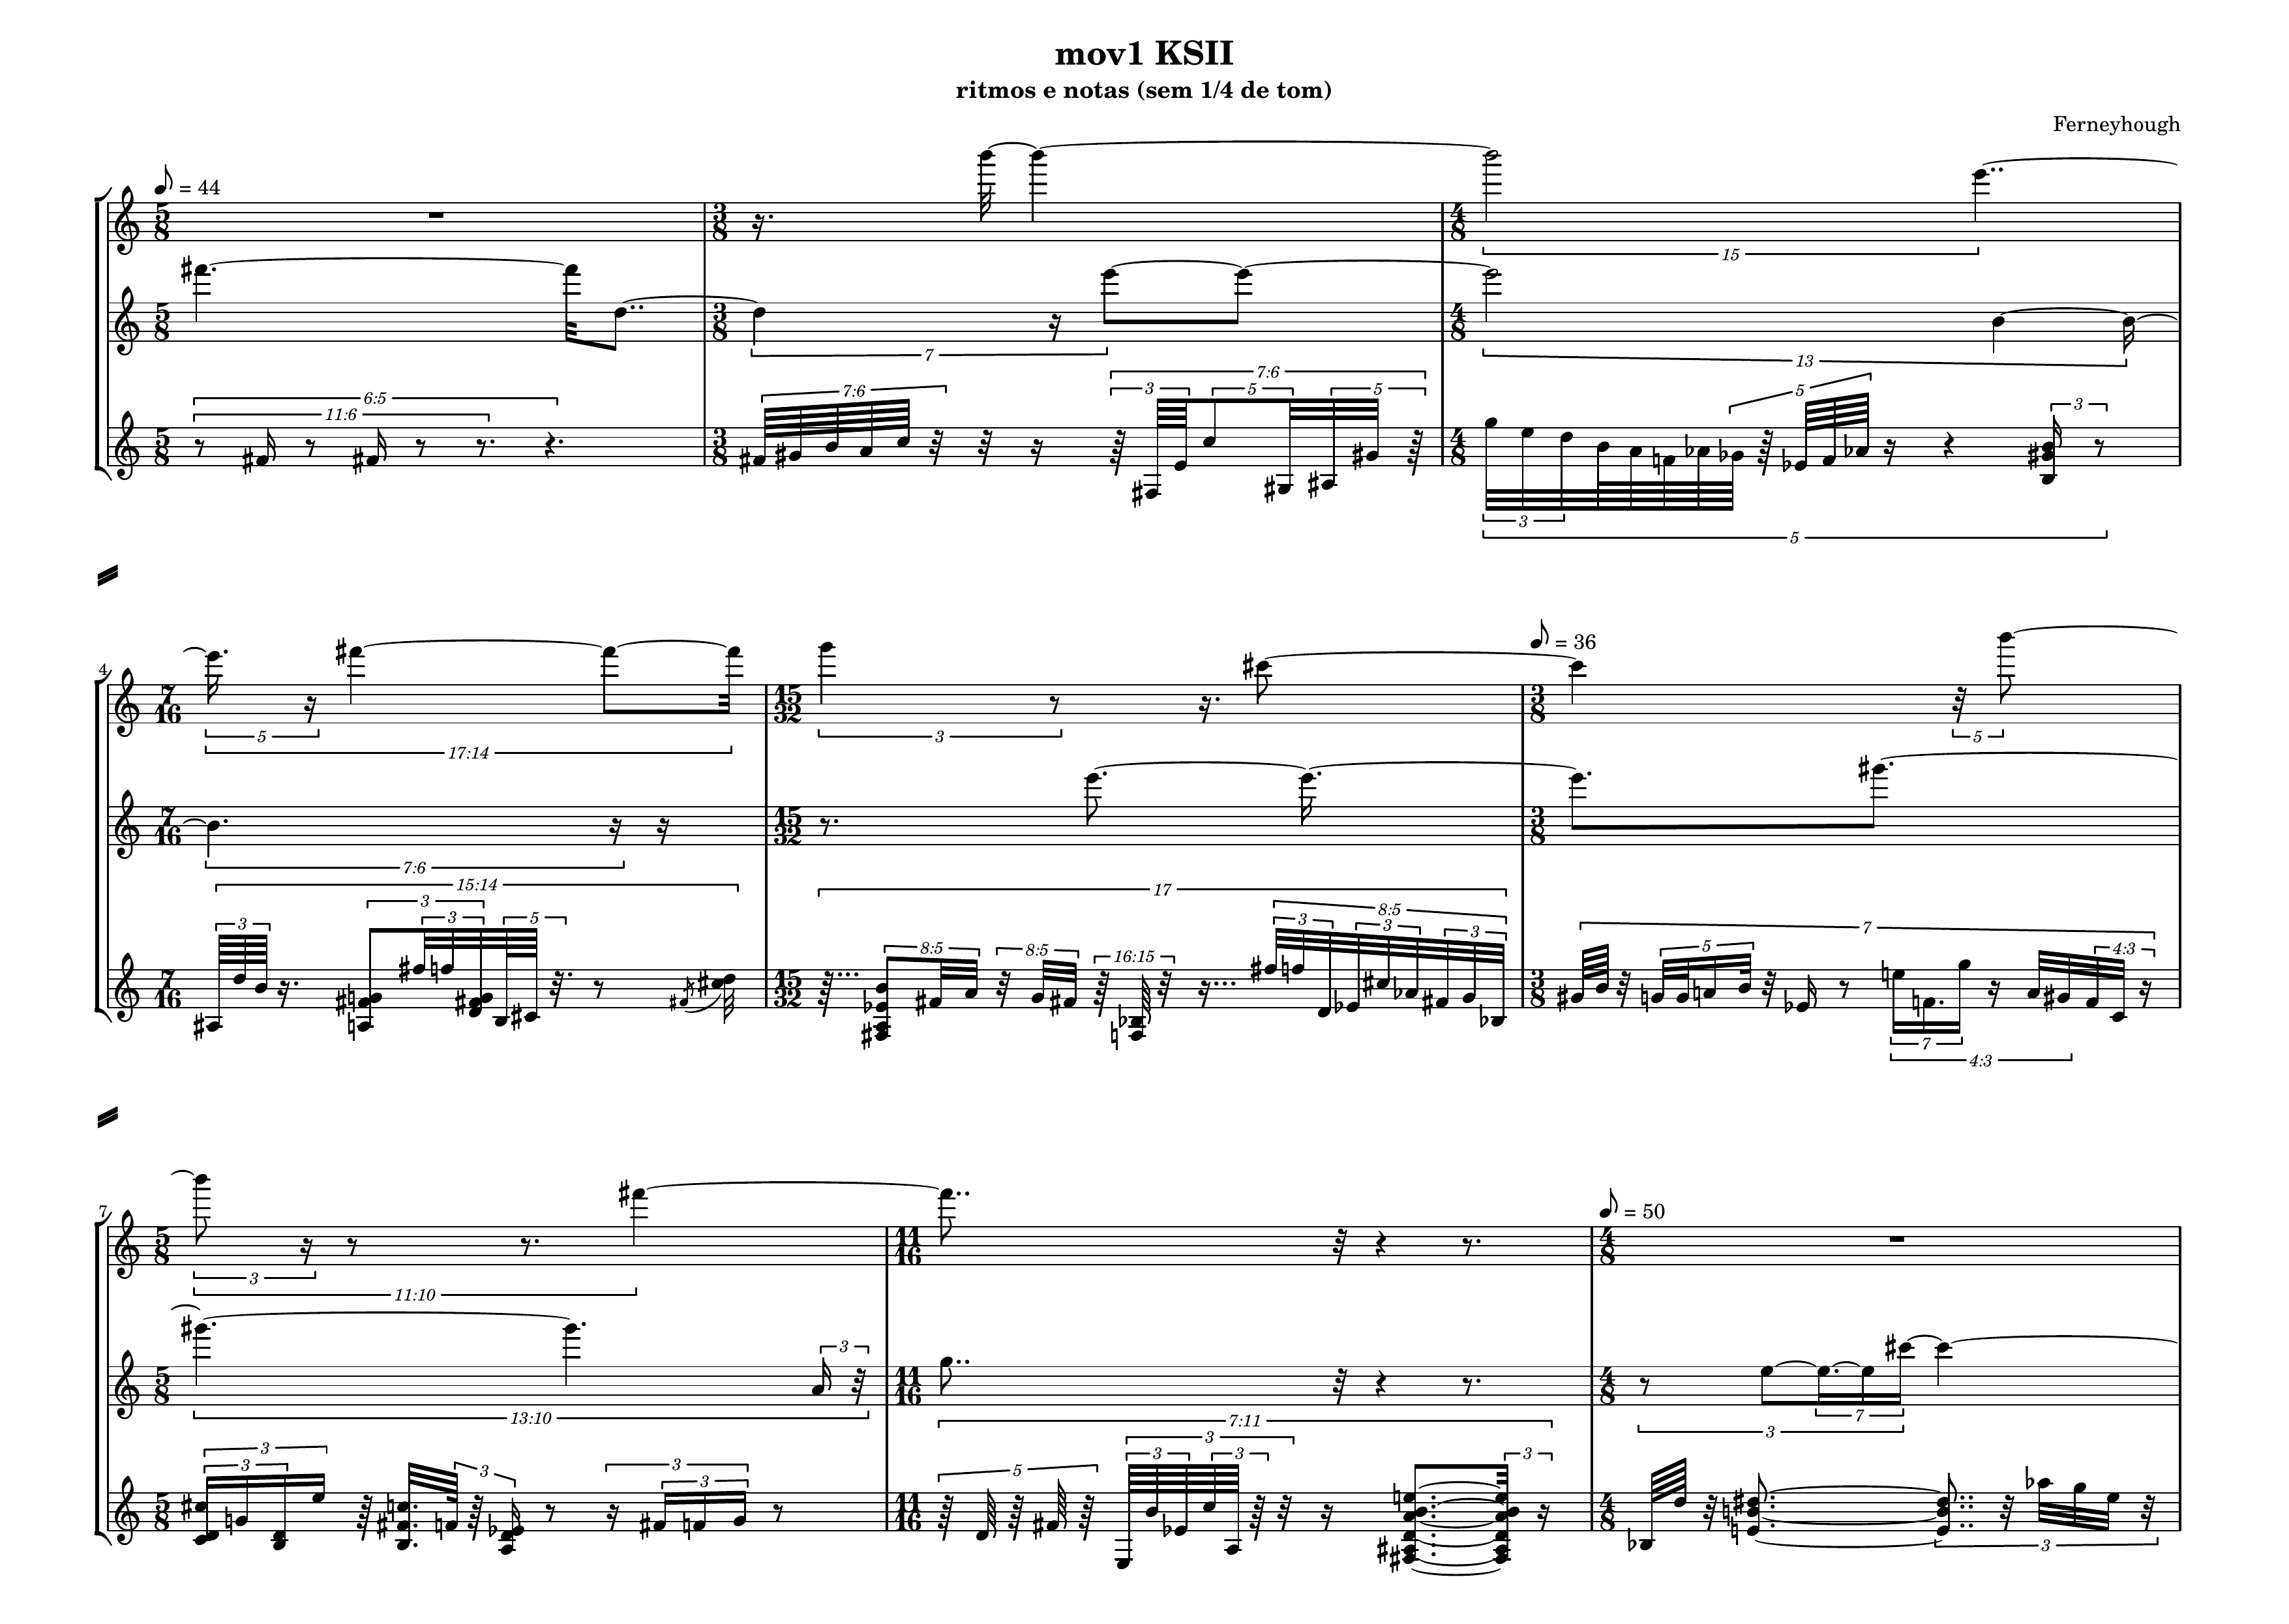

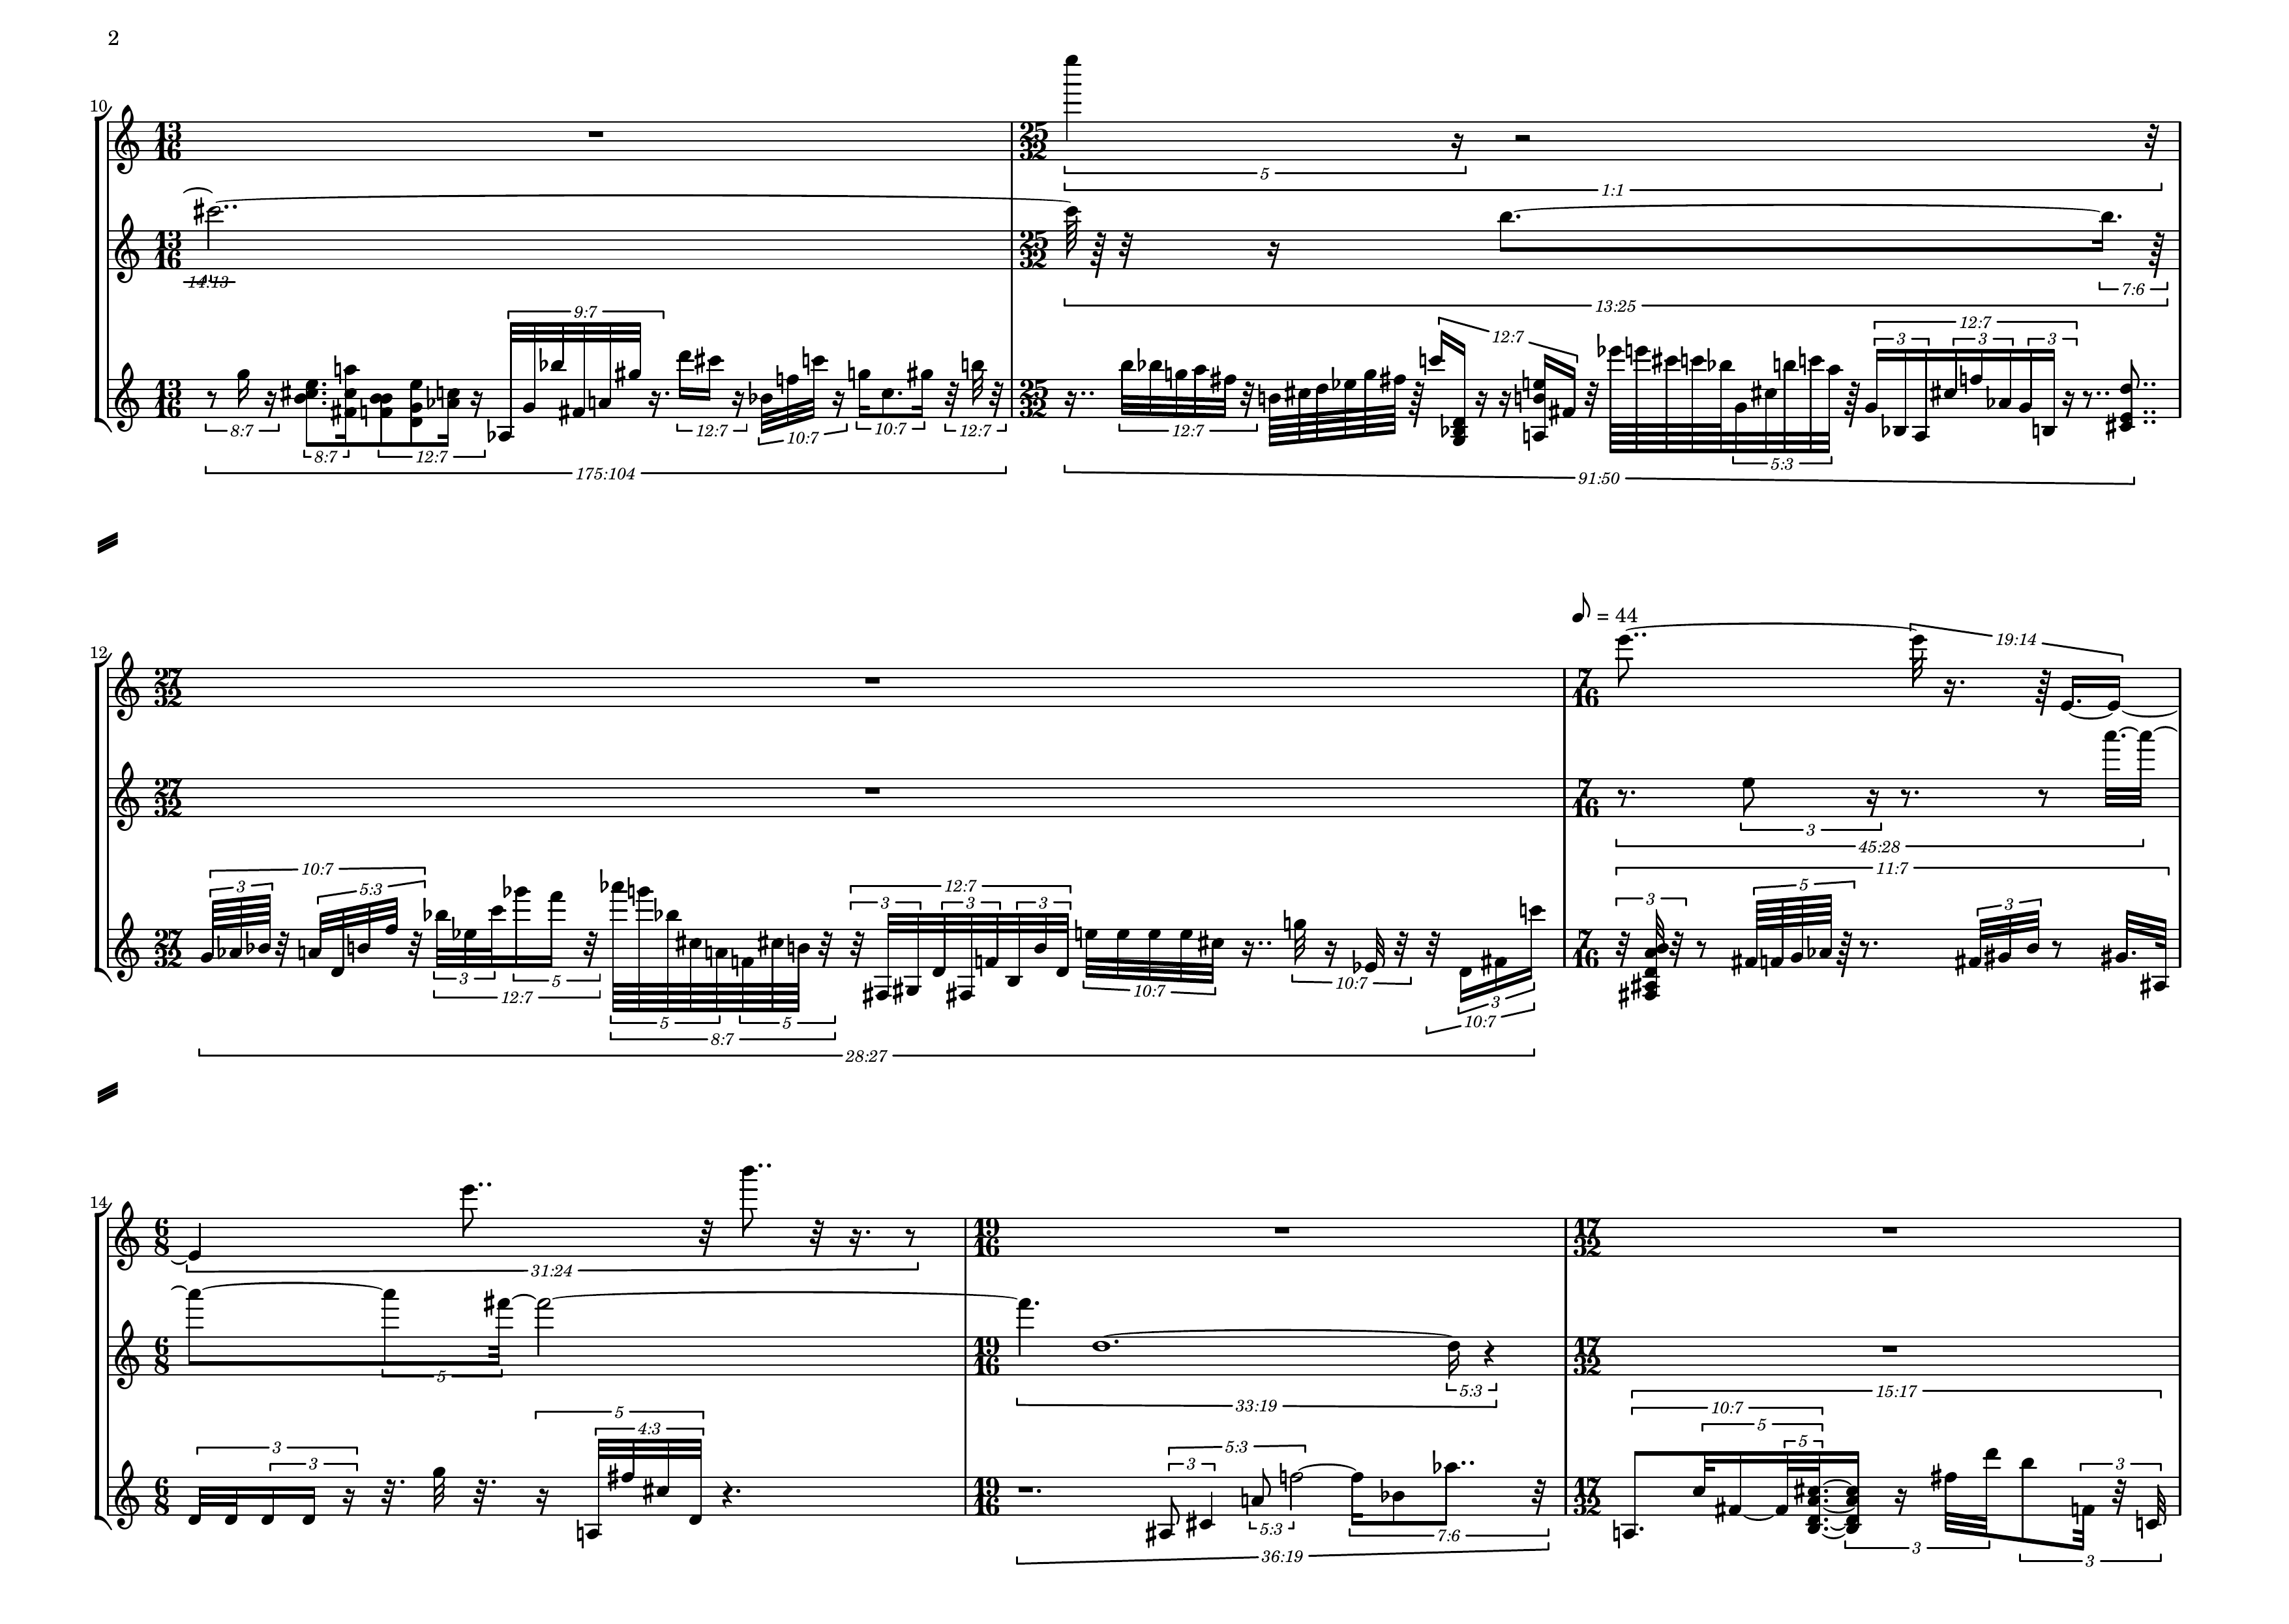

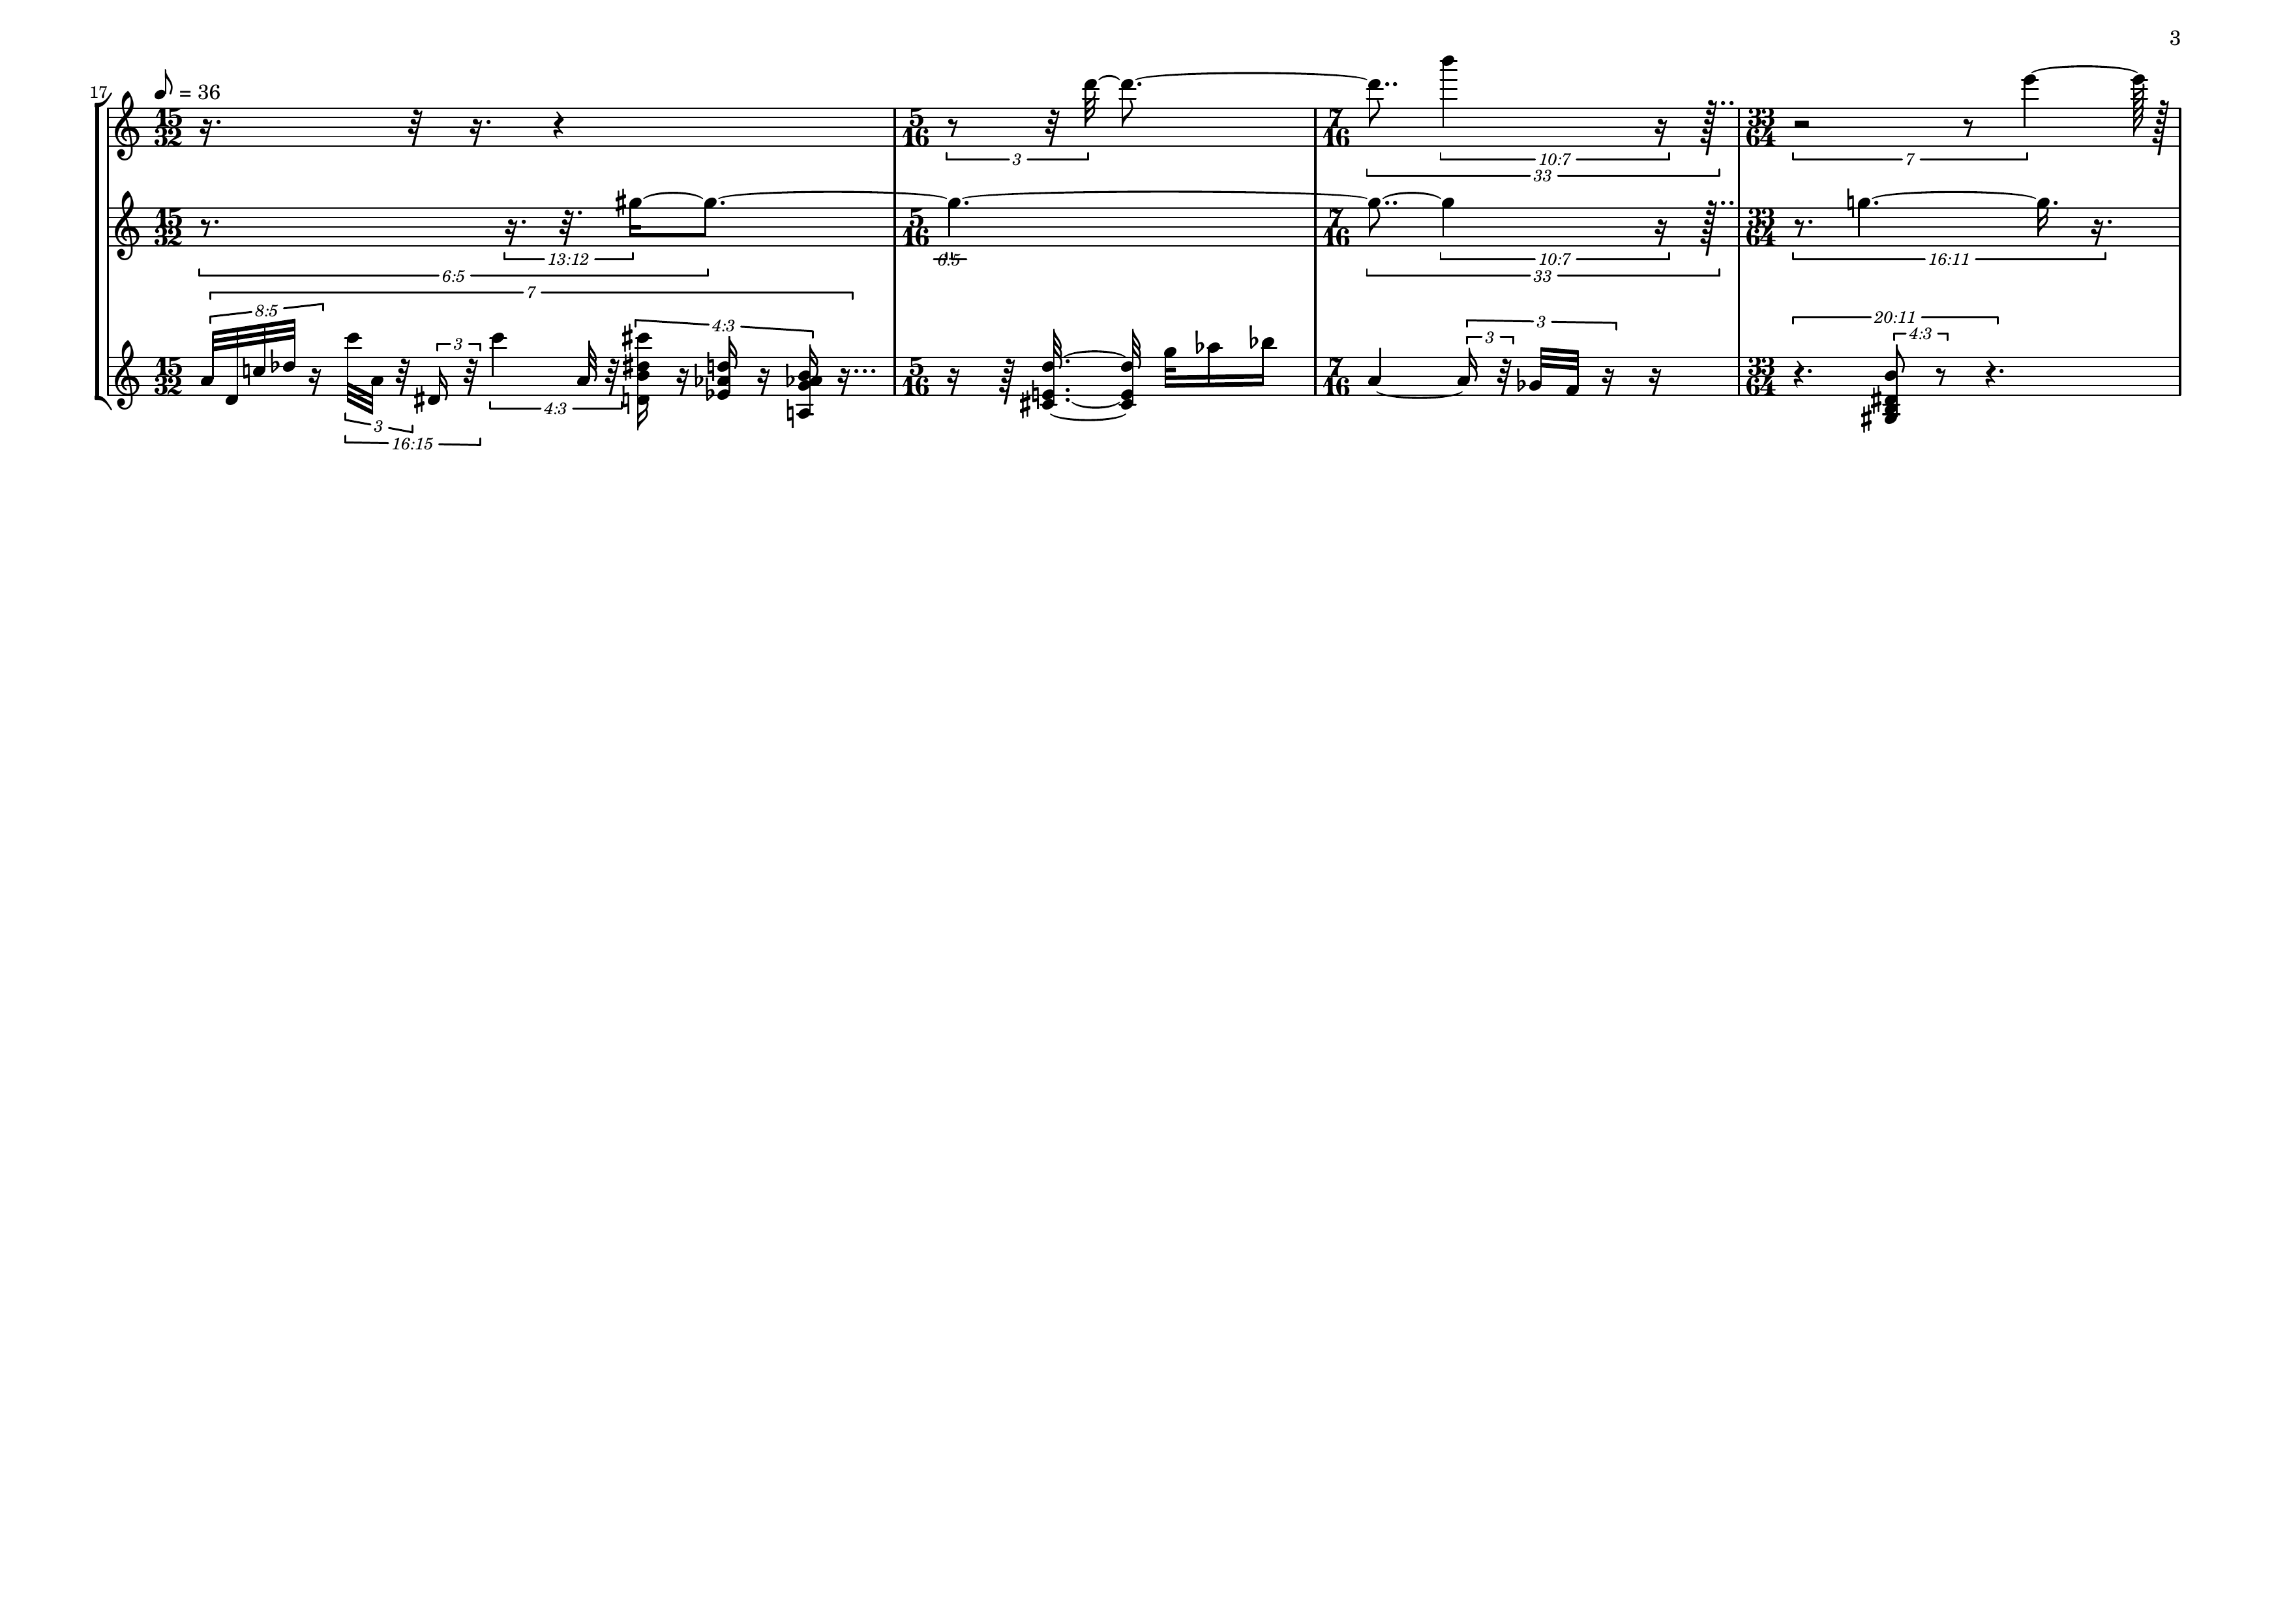

## Referências:
- FERNEYHOUGH, Brian. (1990). *Kurze Schatten II*. Frankfurt am Main: Edition Peters.
- FERNEYHOUGH, Brian. Duration ans rhythm as compositional resources. In: BOROS, James (ed.); TOOP, Richard (ed.). *Collected Writings*. Amsterdam: Harwood Academic Publishers, 1995, p.51-65.
- MALT, Mikhail. Brian Ferneyhough et l'aide informatique à l'ecriture. In: SZENDY, Peter (ed.). *Brian Ferneyhough*. Paris: L'Harmattan, Ircam, 1999, p.61-106.